In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

%matplotlib inline

In [3]:
def convert_to_float(value):        
    if "K" in value:
        return float(value[:-1]) * 1000
    if "M" in value:
        return float(value[:-1]) * 1000000
    if "B" in value:
        return float(value[:-1]) * 1000000000
    if "%" in value:
        return float(value[:-1]) / 100
    if value == "-":
        return None
    return float(value.replace(",", ""))

In [4]:
def test_stationarity(data):
    print("Dicky Fuller Test Results:")
    results = adfuller(data, autolag="AIC")
    output = pd.Series(results[:4], index=["Statistics", "p-value", "Lags", "Observations"]).append(pd.Series({"Critical Value (%s)" % key: value for key, value in results[4].items()}))
    print(output)

In [5]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

In [6]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

In [7]:
def inverse_difference(history, yhat, interval=1):
    history = list(history)
    n = len(yhat)
    if len(yhat) == 1:
        value = yhat[i] + history[-interval]
        history.append(value)
    else:
        value = yhat[0] + history[-interval]
        history.append(value)
        
        for i in range(1, n):
            value = yhat[i] + history[-interval]
            history.append(value)
    return np.array(history[-n:])

In [8]:
ether_data = pd.read_csv("Datasets/ETH-USD-Data.csv")
ether_data.rename(columns={"Price": "Close", "Vol.": "Volume", "Change %": "Change"}, inplace=True)
ether_data["Date"] = ether_data['Date'].astype("datetime64")
for column in ether_data.columns[1:]:
    ether_data[column] = ether_data[column].apply(convert_to_float)
ether_data = ether_data.reindex(columns=["Date", "Open", "High", "Low", "Close", "Volume", "Change"]).set_index("Date").sort_values("Date")
ether_data = ether_data.interpolate()
ether_data_close = ether_data.drop(columns=ether_data.columns[:3].append(ether_data.columns[4:]))
# ether_data_close = ether_data["Close"]

In [59]:
ether_data_close = ether_data_close.iloc[:1577]

In [60]:
ether_data_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1577 entries, 2016-03-10 to 2020-07-03
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1577 non-null   float64
dtypes: float64(1)
memory usage: 24.6 KB


In [61]:
ether_data_close.describe()

,Close
count,1577.000000
mean,229.267952
std,230.500325
min,6.700000
25%,49.660000
50%,182.720000
75%,288.920000
max,1380.000000


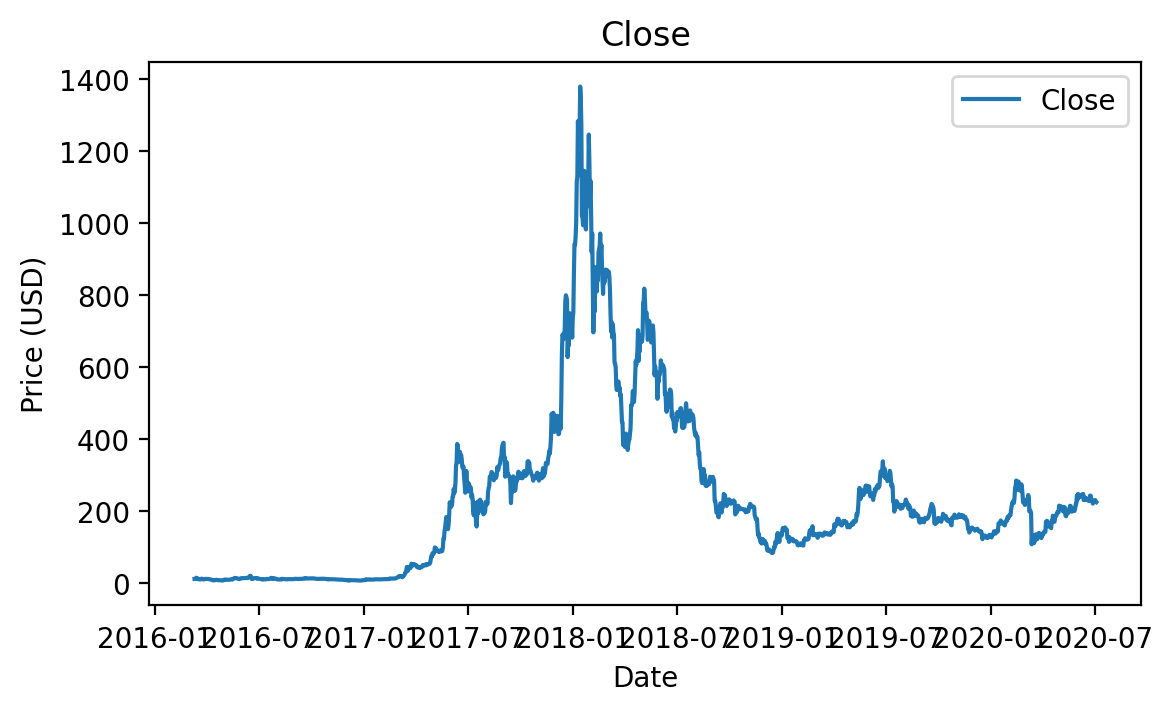

In [62]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(ether_data_close["Close"], label="Close")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Close")
plt.show()

In [63]:
test_stationarity(ether_data_close["Close"])

Dicky Fuller Test Results:
Statistics                -2.229659
p-value                    0.195658
Lags                      24.000000
Observations            1552.000000
Critical Value (1%)       -3.434570
Critical Value (5%)       -2.863404
Critical Value (10%)      -2.567762
dtype: float64


C:\Users\samee\AppData\Local\Temp\ipykernel_12732\2986207081.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = pd.Series(results[:4], index=["Statistics", "p-value", "Lags", "Observations"]).append(pd.Series({"Critical Value (%s)" % key: value for key, value in results[4].items()}))


In [64]:
training_size = int(len(ether_data_close["Close"]) * 0.90)
test_size = len(ether_data_close["Close"]) - training_size
train_ether_data = ether_data_close[:training_size]
test_ether_data = ether_data_close[training_size:]

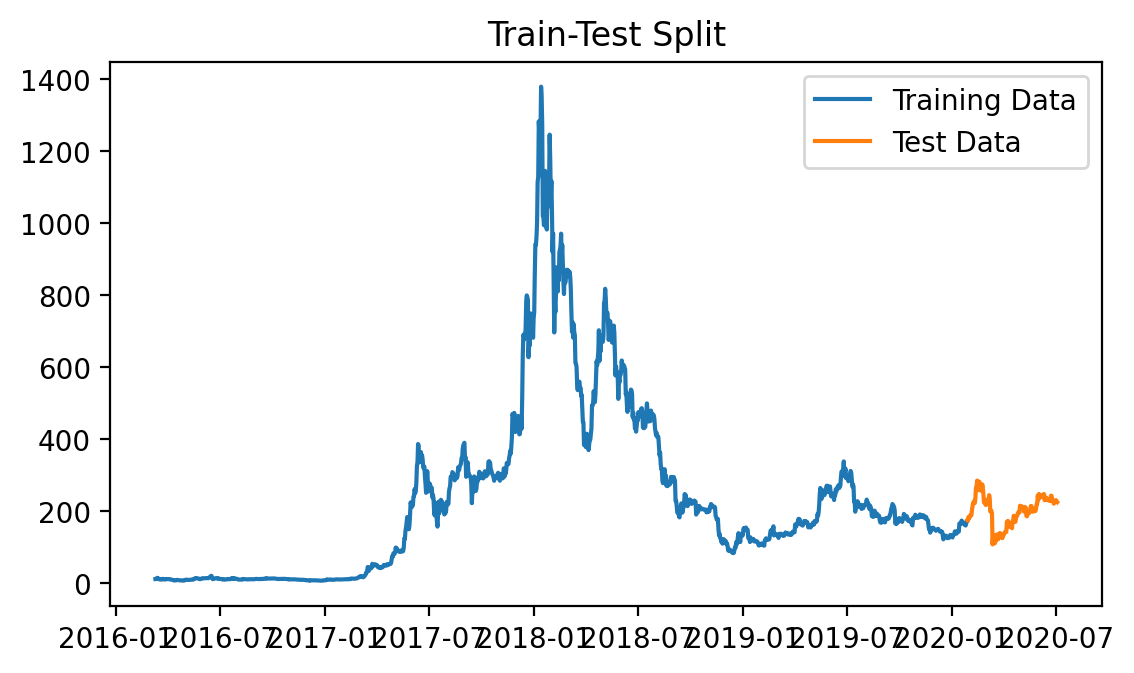

In [65]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(train_ether_data, label = "Training Data")
plt.plot(test_ether_data, label = "Test Data")
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [66]:
diff_close = difference(train_ether_data["Close"].values, 1)

In [67]:
test_stationarity(diff_close)

Dicky Fuller Test Results:
Statistics             -6.097276e+00
p-value                 1.003024e-07
Lags                    2.400000e+01
Observations            1.393000e+03
Critical Value (1%)    -3.435053e+00
Critical Value (5%)    -2.863617e+00
Critical Value (10%)   -2.567876e+00
dtype: float64


C:\Users\samee\AppData\Local\Temp\ipykernel_12732\2986207081.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = pd.Series(results[:4], index=["Statistics", "p-value", "Lags", "Observations"]).append(pd.Series({"Critical Value (%s)" % key: value for key, value in results[4].items()}))


In [70]:
arima_model = ARIMA(diff_close, order=(5, 0, 5))
fitted_arima = arima_model.fit()
fitted_arima.summary()

c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1418
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -6315.094
Date:                Wed, 11 May 2022   AIC                          12654.189
Time:                        11:31:19   BIC                          12717.273
Sample:                             0   HQIC                         12677.756
                               - 1418                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1129      0.765      0.148      0.883      -1.386       1.612
ar.L1          1.2403      0.042     29.339      0.000       1.157       1.323
ar.L2         -0.6562      0.085     -7.699      0.000      -0.823      -0.489
ar.L3         -0.2102      0.102     -2.055      0.040      -0.411      -0.010
ar.L4          0.7103      0.082      8.707      0.000       0.550       0.870
ar.L5         -0.6269      0.041    -15.480      0.000      -0.706      -0.548
ma.L1         -1.1808      0.038    -31.001      0.000      -1.255      -1.106
ma.L2          0.6298      0.079      8.010      0.000       0.476       0.784
ma.L3          0.2394      0.096      2.481      0.013       0.050       0.428
ma.L4         -0.7833      0.079     -9.957      0.000      -0.937      -0.629
ma.L5          0.7797      0.039     20.196      0.000       0.704       0.855
sigma2       431.9018      5.758     75.006      0.000     420.616     443.188
===================================================================================
Ljung-Box (L1) (Q):                   2.91   Jarque-Bera (JB):             28663.51
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               2.39   Skew:                            -0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
predicted_diff_close = fitted_arima.forecast(7)
predicted = inverse_difference(train_ether_data["Close"], predicted_diff_close)
actual = np.array(test_ether_data["Close"][:7])

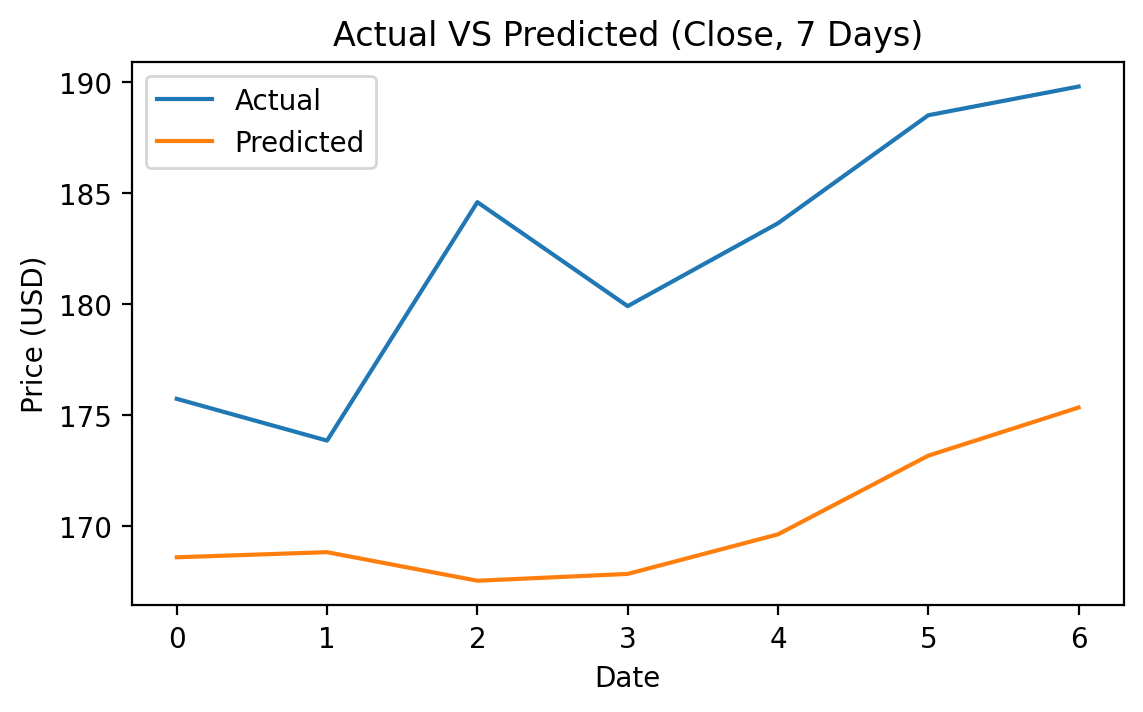

In [73]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(actual, label="Actual")
plt.plot(predicted, label="Predicted")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Actual VS Predicted (Close, 7 Days)")
plt.show()